<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Challenge" data-toc-modified-id="Challenge-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Challenge</a></span></li><li><span><a href="#Angle-Deficiency-Design-for-PID-Control" data-toc-modified-id="Angle-Deficiency-Design-for-PID-Control-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Angle Deficiency Design for PID Control</a></span><ul class="toc-item"><li><span><a href="#Example" data-toc-modified-id="Example-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Example</a></span></li></ul></li><li><span><a href="#Exercise:-Due-Thursday,-November-14-by-MIDNIGHT" data-toc-modified-id="Exercise:-Due-Thursday,-November-14-by-MIDNIGHT-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Exercise: Due Thursday, November 14 by MIDNIGHT</a></span></li></ul></div>

# Challenge

In today's notebook, you will learn how you can gain more control over the branches of a higher-order system and still maintain zero steady state error in your control system by using Proportional-Integral-Derivative (PID) control.

PID control adds TWO zeros to the forward path of our control system, rather than the single zero afforded by PD or PI. This means that it reduces our number of root locus asymptotes by 1 (like PD, but *unlike* PI), which is useful for limiting the possibility that our closed loop system could go unstable if the root locus gain K is turned up too high.

There are many approaches for designing and tuning PID controllers that are used in industry. Some of these are almost entirely empirical and iterative (a popular example is the so-called "Ziegler Nichols" method), and some are model-based. In ME480, we will use the root locus as our primary design tool for PID controllers, which will help you develop good intuition and build a toolset that is rooted in model-based design.

# Angle Deficiency Design for PID Control

The angle deficiency method is a simple, direct method for designing P, PI, and PD controllers for many types of systems you may encounter in industry or in graduate school. However, using all three terms in the canonical "PID" controller is also common. The PID controller, in its full form, has the following controller transfer function when a summing gain $K_{sum}$ is included:

$$C(s) = K_{sum}\left(K_p + K_ds + \frac{K_i}{s}\right)$$

Factoring out a $\frac{1}{s}$ yields:

$$C(s) = \frac{K_{sum}\left(K_ds^2+ K_ps + K_i\right)}{s}$$

Factoring out $K_d$ to clear the term multiplied by the highest power of $s$ gives us:

$$C(s) = \frac{K_{sum}K_d\left(s^2+ \frac{K_p}{K_d}s + \frac{K_i}{K_d}\right)}{s}$$

Assuming that we can factor the numerator of the control transfer function allows us to write it as follows:

$$C(s) = K\frac{(s+z_1)(s+z_2)}{s}$$

Which tells us that the PID controller adds *two* zeros and one pole at $s=0$ to our "open loop transfer function" $G(s)H(s) = C^\star P(s)H(s)$. These zeros could be either two distinct real numbers, two repeated zeros, or a complex conjugate pair, depending on the ratios $\frac{k_i}{k_d}$ and $\frac{k_p}{k_d}$.

Why is this important? Well, for one thing, many systems (think third and higher order systems) are still at risk of eventually going unstable under PI control, especially at higher overall gains $K$, because the PI controller does *not* reduce the number of asymptotes on the root locus $a=n-m$, also called the *net order* of the closed loop system. PID control will reduce $a=n-m$ because of its second zero. In many cases, this will have the effect of *bending root locus branches to the left*, possibly keeping the system from going unstable at high gain. 

It is also common to develop a PD control system for a plant that does not inherently result in zero steady-state error. In this situation, adding an integral term to the PD controller can eliminate steady-state error, but the integral controller adds a pole at the origin to the open-loop transfer function and changes the shape of the root locus. In this type of design problem, PID design may be a good choice as well.

While the addition of a second zero in $C(s)$ from a PID design can have very nice effects on our system performance and/or root locus shape, it does present design challenges. The two zeros $z_1$ and $z_2$ can be either two real numbers or a complex conjugate pair, and placing them adds another unknown to our design problem. This means that the one design equation we've been using, the angle criterion,

$$\angle \left.G(s)H()s\right|_{s=s_d}=\pm 180^\circ$$

Is no longer enough to complete our design directly. We often will need to iterate on a PID design to achieve a balance between our performance goals and any other design constraints we may have. These often include, but are not limited to:

1. Voltage limits for our control hardware
2. A guarantee of stability for all root locus gains $K=K_{sum}K_d$

The unfortunate thing is that there isn't a "magic bullet" for every design problem, even with the angle deficiency design methodology. You may have to try a design, check voltage limits, inspect your new root locus to determine if stability is guaranteed, and iterate. The fortunate thing is that your experience with root locus sketching and angle deficiency design should help you develop intuition for zero placement in controller design based on the root locus of the system you're trying to control. Developing this intuition is truly the goal of working with the concrete design tools we have. With solid intuition as a controls engineer, and solid tools to analyze and support your design, you will be able to solve many difficult control problems efficiently.

## Example

Say we want to control the following plant transfer function $P(s)$ with the following sensor transfer function $H(s)$. The sensor transfer function $H$ might represent a simple low-pass filter we use when measuring our system's output $y$.

In designing a controller for this system, we wish to hit a design eigenvalue for the slowest branch of $s_d = -4.5+4j$.

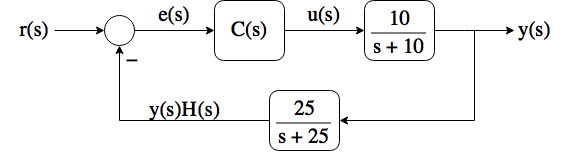

Our first step, as usual, is to assume that we might be able to hit our desired pole location using a simple proportional controller, with $C(s) = K_p = K$. This sets us up to sketch a root locus with $G(s)H(s)=\frac{250}{(s+10)(s+25)}$ as shown below. 

In [ ]:
pkg load control
s = tf('s');
sd = -4.5+4j;

P = 10/(s+10);
H = 25/(s+25);

rlocus(P*H)
hold on
plot(real(sd),imag(sd),'r.','MarkerSize',20)

As you can see, our desired pole location lies to the right of our slowest root locus branch. This should be a big hint to try a PI controller first. Just to confirm that the "angle deficiency" $\alpha = 180-\angle\left. (G(s)H(s))\right|_{s_d}$ is negative, let's compute it. We've done this plenty of times by hand this semester, so let's use MATLAB to do the heavy lifting instead.

In [ ]:
%find the numerator and denominator coefficients of our root locus "open loop" TF
[num_ph,den_ph] = tfdata(P*H,'v');
%find the poles of the open loop tf for p-control
poles_PH = roots(den_ph);
%there are two of these poles... so let's use them to calculate the angles for the angle deficiency method.
%remember that the angle from a pole to a point sd is the same as saying angle(sd+p), where the pole is at -p.
ang_p1 = atan2d(imag(sd)-imag(poles_PH(1)),real(sd)-real(poles_PH(1)))
ang_p2 = atan2d(imag(sd)-imag(poles_PH(2)),real(sd)-real(poles_PH(2)))
alpha = 180-(0-ang_p1-ang_p2)-360

This calculation has confirmed for us that we have a "negative angle deficiency," which means we should attempt a PI control design with the following block diagram representation:

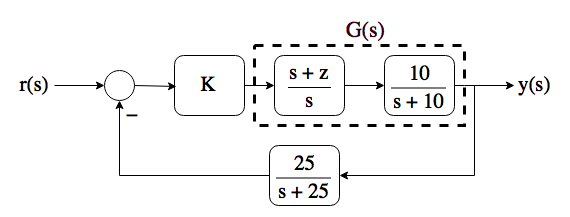

In this diagram, $C(s) = K_{sum}(K_p+\frac{K_i}{s})$, and we can factor out $K_p$ to obtain $C^\star=\frac{s+z}{s}$ and $K=K_pK_{sum}$ ($K_{sum}$ will be set to 1 for this example). We'll once again use MATLAB to help us get the angles for the angle deficiency calculation. For more details on this process, please see the "angle deficiency design intro" notebook. Note that you will need to be proficient in performing this design process without MATLAB for the exam, so use this as an opportunity to practice, rather than just "believing" the angles MATLAB gives us!

In [ ]:
%find the angle from the new pole at 0 to the desired pole location:
ang_p3 = atan2d(imag(sd),real(sd))

%now find the angle from our controller zero to our desired pole location using the angle criterion.
alphaz_PI = 180+ang_p1+ang_p2+ang_p3

%now use this angle to find the horizontal (real) distance from our pole to the new zero
L_PI = imag(sd)/tand(alphaz_PI);
z_PI = abs(real(sd)-L_PI)

Let's use this opportunity to make sure that our zero location was placed properly. Let's look at the root locus to make sure it passes through the desired pole location $s_d$.

In [ ]:
%for our PI system, GH or the "open loop TF" is Cstar*P*H
Cstar = (s+z_PI)/s;
rlocus(Cstar*P*H)
hold  on
plot(real(sd),imag(sd),'r.','MarkerSize',10)

It looks like we're in good shape. But there's a problem! At sufficiently high gain, our system goes unstable!! This is going to be our motivation for a PID design. Adding a second zero will allow us to "pull the branches around" so that they rejoin the real axis, leaving us with only one root locus asymptote at $\pi$ radians. 

But before we go down that path, let's finish the PI design. We can use the magnitude criterion and the zero location to find our control gains. 

In [ ]:
%find the root locus gain K using magnitude criterion
mag_GH_at_sd = abs(250*(sd+z_PI)/(sd*(sd+10)*(sd+25)))
K = 1/(mag_GH_at_sd)
Ksum=1;
%kp*ksum = K
Kp = K/Ksum
%z = Ki/Kp
Ki = z_PI*Kp

The final step in finishing our PI design is to simulate its behavior. We'll also print the closed-loop eigenvalues of our system to make sure that one of them is $s_d$.

In [ ]:
%build 'real' version of the control TF so that we can confirm we got the gains right.
C = Ksum*(Kp+Ki/s);
%find closed loop TF y/r
Gcl_PI = minreal(C*P/(1+C*P*H))
%pull out numerator and denominator coeffs
[num_cl_pi,den_cl_pi] = tfdata(Gcl_PI,'v');
%find eigs
eigs_closedloop_pi = roots(den_cl_pi)
%now simulate our system's response (y) to a unit step request (r)
step(Gcl_PI)

So our response looks great, but the problem is that as we increase our summing gain $K_{sum}$, perhaps in an attempt to speed the system up, we "walk along the locus" towards instability. So, we'll attempt to use a PID control's advantage of a second, independent zero to help us out. From above, recall that the PID controller can be written:

$$C(s) = K_{sum}\left(K_p + K_ds + \frac{K_i}{s}\right)=\frac{K_{sum}K_d\left(s^2+ \frac{K_p}{K_d}s + \frac{K_i}{K_d}\right)}{s}=K\frac{(s+z_1)(s+z_2)}{s}$$

So we have the option of placing two real zeros or two complex conjugate zeros. We also have to update our "open loop transfer function" for the root locus according to the following block diagram:

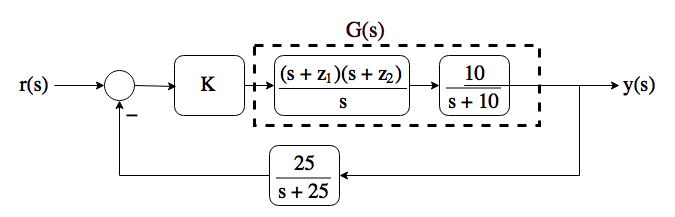

So now, we will be working with the root locus of: 
$$G(s)H(s) = C^\star(s)P(s)H(s)= \frac{250(s+z_1)(s+z_2)}{s(s+10)(s+25)}$$

And we'll have to somehow place both zeros $z_1$ and Z_2$. Let's use MATLAB to explore the following options:

1. Place two real zeros
2. Place two complex conjugate zeros

We'll just use MATLAB to see what consequences each of these options might have for our system. Once we decide what option is best for us, we'll use the angle deficiency criterion again (with an additional constraint) to make sure we hit our desired eigenvalue $s_d$. First, let's explore option 1, where we will place two real zeros.

In [ ]:
%let's use a constant zero separation of 5 so z2 = z1+5 to place two real zeros in different spots.
figure()
hold on
for k=1:5
%guess at zero locations
z1 = k*15;
z2 = z1+5;
%find our root locus for this configuration
Cstar_PID = ((s+z1)*(s+z2))/s;
GH_PID = Cstar_PID*P*H;
rlocus(GH_PID)
end
    

As you can see, by placing the control zeros close to one another, we cause the root locus to "loop" because of the reduction in the "net order" or number of asymptotes $a=n-m$ for our system.  We can also see that even for large zeros, the system appears "safe" from going unstable. For any of the zero locations we tried, we can confirm whether the system goes unstable without the help of MATLAB by attempting to solve for the system's crossing frequency and critical gain.

So what about option 2? What happens if we place two complex conjugate zeros with a varying "real" component and some known damping ratio?

In [ ]:
%let's use a constant zero separation of 5 so z2 = z1+5 to place two real zeros in different spots.
%for the complex conjugate zeros, let's make them have a damping ratio of 0.707 so the real and imaginary compoenents are the same.
figure()
hold on
for k=1:5
%guess at zero locations
z1 = k*15+k*15*j;
z2 = k*15-k*15*j;
% Cstar_PID = ((s+z1)*(s+z2))/s
Cstar_PID = 1/s*(s^2+(z1+z2)*s+z1*z2)
GH_PID = Cstar_PID*P*H;
rlocus(GH_PID)
end

As you can see, the story here is a little different. If we place "fast" zeros that are complex, even though the  real components of the two zeros are approximately the same as they were for our "test" zeros, the closed-loop system appears to bend into the unstable region more quickly. Be careful reading into this too much... the story may be different for a different configuration of $G(s)H(s)$, so it is a good idea to take PID designs on a case-by-case basis, and think critically about the consequences of your design decisions on the root locus. 

For our example, it looks like two real zeros is the way to go. But we still have to place them! For simplicity, let's choose two real zeros that are *at the same location*, so that each of their angles, $\alpha_{z1}$ and $\alpha_{z2}$ are the same. This makes the angle criterion equation easy to use to solve for both angles simultaneously:

$$\left.\angle(G(s)H(s)\right|_{s_d} = \pm 180^\circ = \alpha_{z1}+\alpha_{z2}-\angle(p1\rightarrow s_d)-\angle(p2\rightarrow s_d)-\angle(p3\rightarrow s_d)$$

Because $\alpha_{z1}=\alpha_{z2}$, it should be easy to solve for each angle using MATLAB.

In [ ]:
%now find the angle from our controller zero to our desired pole location using the angle criterion.
alphaz_PID = 0.5*(-180+ang_p1+ang_p2+ang_p3)

%now use this angle to find the horizontal (real) distance from our pole to the new zero
L_PID = imag(sd)/tand(alphaz_PID);
z_PID = abs(real(sd)-L_PID)

%now confirm that our root locus hits our desired point and does not go unstable
rlocus((s+z_PID)^2/s*P*H,.001,0,10)
hold on
plot(real(sd),imag(sd),'r.','MarkerSize',20)
axis([-50 50 -50 50])

Now that we have a location for our zeros $z_1$ and $z_2$, and confirmed that this design hits our desired point (and satisfies our other criterion of never going unstable), we can use the controller transfer function to find our gains. The relationship between our zero locations and our gains is given by equating coefficients in the two forms of the controller transfer function:


$$C(s) = \frac{K_{sum}K_d\left(s^2+ \frac{K_p}{K_d}s + \frac{K_i}{K_d}\right)}{s}=K\frac{s^2+(z_1+z_2)s+z_1z_2}{s}$$

So for us, we find that:

$$K={K_d}{K_{sum}}$$

where $K$ comes from the magnitude criterion. Additionally, equating coefficients tells us:

$$\frac{K_p}{K_d} = (z_1+z_2) = 2z$$

and also that:

$$\frac{K_i}{K_d} = z_1z_2 = z^2$$

for our system, where we decided to place $z_1$ and $z_2$ at the same location on the real axis. Now, we can use MATLAB to come up with our controller gains $K_p,K_i,K_d$.

In [ ]:
mag_GH_PID = abs(250*((sd+z_PID)^2)/(sd*(sd+10)*(sd+25)))
K_PID = 1/mag_GH_PID;
Ksum_PID = 1.0;
Kd_PID = K_PID/Ksum_PID
Kp_PID = 2*z_PID*Kd_PID
Ki_PID = z_PID^2*Kd_PID

Take a moment to compare these numbers to what we had before with PI control. They're very, very similar. $K_d$, the "new" derivative gain, is very small. We added "a little bit" of derivative control to prevent the system from going unstable, and adjusted the other two gains slightly to ensure that we still nailed our desired closed loop pole $s_d$. Let's see how the system performs, and compare its performance to our PI controller. We expect very similar results because the systems have the same "slowest branch" eigenvalue, but the differences in zeros may cause the closed loop behavior to differ slightly.

In [ ]:
C_PID = Ksum_PID*(Kp_PID+Kd_PID*s+Ki_PID/s);
Gcl_PID = minreal(C_PID*P/(1+C_PID*P*H))

%pull out numerator and denominator coeffs
[num_cl_pid,den_cl_pid] = tfdata(Gcl_PID,'v');
%find eigs
eigs_closedloop_pid = roots(den_cl_pid)
%now simulate our system's response (y) to a unit step request (r). Also simulate for PI to compare
step(Gcl_PID,Gcl_PI)
legend('PID Control','PI Control')

As you can see, the two systems respond almost identically, which is great! The PID control system just gives us the added benefit of "safety" when the summing gain $K_{sum}$ is turned up, or when some other gain factor in the system varies from our design value, because we know that if our model is good, the system will not go unstable under PID control.

**NOTE**: Keep in mind that even with PID control, our system actually gets pretty close to going unstable. Think about what we might do to keep this from happening. Based on what you saw in the "exploratory" zero placement blocks above, what could you do to make sure that the system stayed farther away from the right half of the s-plane?